In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [3]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [4]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result
def slicing(dataset, index, i):
    return dataset.slice(index).kmer_index_encoding()[i]

def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

# kmer LSTM (with LR) vs kmer FFNN

In [6]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0





train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))
nine_train_nn_aucs = np.zeros((folds,n_epochs))
nine_test_nn_aucs = np.zeros((folds,n_epochs))
non_nine_train_nn_aucs = np.zeros((folds,n_epochs))
non_nine_test_nn_aucs = np.zeros((folds,n_epochs))


train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    

    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr=0.01)
    lstm.compile(optimizer = adam, loss='mean_squared_error')
    
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
  
    
    for epoch in range(n_epochs):
        
        
        
        
        # nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped = regroup_together(nn.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped = regroup_together(nn.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped = regroup_together(nn.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped = regroup_together(nn.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped)     
        nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped)
        non_nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped)     
        non_nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped)
        
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        nine_train_nn_aucs[i][epoch]=nine_train_nn_auc
        nine_test_nn_aucs[i][epoch]=nine_test_nn_auc
        non_nine_train_nn_aucs[i][epoch]=non_nine_train_nn_auc
        non_nine_test_nn_aucs[i][epoch]=non_nine_test_nn_auc
        
        
        
        #lstm 
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_lstm, nb_epoch=1)
    
    
        train_pred_lstm_grouped = regroup_together(lstm.predict(X_train), weights_train, original_indices_train)
        test_pred_lstm_grouped = regroup_together(lstm.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500),train_pred_lstm_grouped)
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500),test_pred_lstm_grouped)
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500),nine_train_pred_lstm_grouped)
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500),nine_test_pred_lstm_grouped)
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500),non_nine_train_pred_lstm_grouped)
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500),non_nine_test_pred_lstm_grouped)
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc
        
        print("All: ", test_nn_auc, test_lstm_auc, epoch, i)
        print("9mer: ", nine_test_nn_auc, nine_test_lstm_auc, epoch, i)
        print("non9mer: ", non_nine_test_nn_auc ,non_nine_test_lstm_auc, epoch, i)
  

Epoch 1/1
21962/21962 [==============================] - 2s - loss: 0.0132     
Epoch 1/1
21962/21962 [==============================] - 26s - loss: 0.0141    
All:  0.938204473209 0.896309280398 0 0
9mer:  0.946329824634 0.897144224947 0 0
non9mer:  0.91442026442 0.895033345033 0 0
Epoch 1/1
21962/21962 [==============================] - 1s - loss: 0.0088     
Epoch 1/1
21962/21962 [==============================] - 27s - loss: 0.0107    
All:  0.945262845316 0.919215113315 1 0
9mer:  0.952641544821 0.922004009698 1 0
non9mer:  0.925295425295 0.912074412074 1 0
Epoch 1/1
21962/21962 [==============================] - 1s - loss: 0.0085     
Epoch 1/1
21962/21962 [==============================] - 24s - loss: 0.0094    
All:  0.947472080456 0.92306025577 2 0
9mer:  0.955251017198 0.926267204148 2 0
non9mer:  0.926266526267 0.914431964432 2 0
Epoch 1/1
21962/21962 [==============================] - 1s - loss: 0.0084     
Epoch 1/1
21962/21962 [==============================] - 24s - loss

KeyboardInterrupt: 

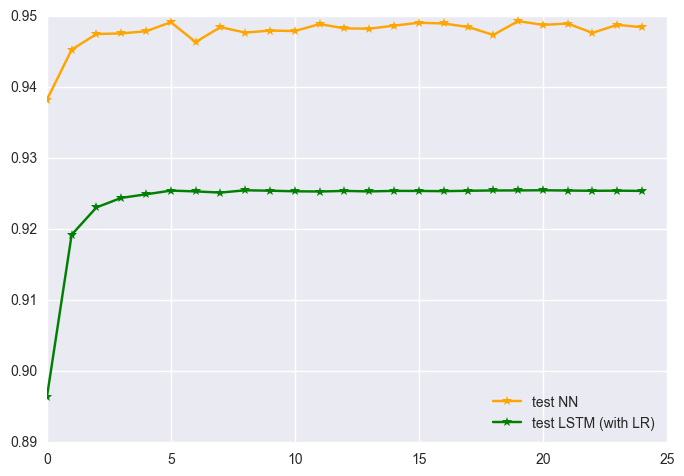

In [7]:
plt.plot( np.arange(0,25,1), test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN")
plt.plot( np.arange(0,25,1), test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (with LR)")

plt.legend(loc=4)

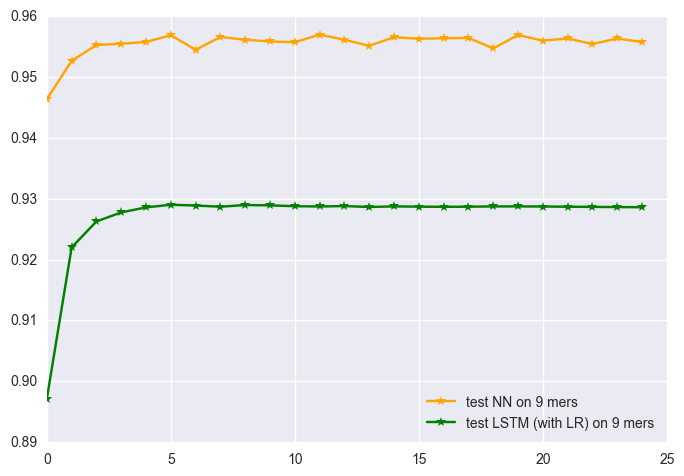

In [8]:
plt.plot( np.arange(0,25,1), nine_test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN on 9 mers")
plt.plot( np.arange(0,25,1), nine_test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (with LR) on 9 mers")

plt.legend(loc=4)

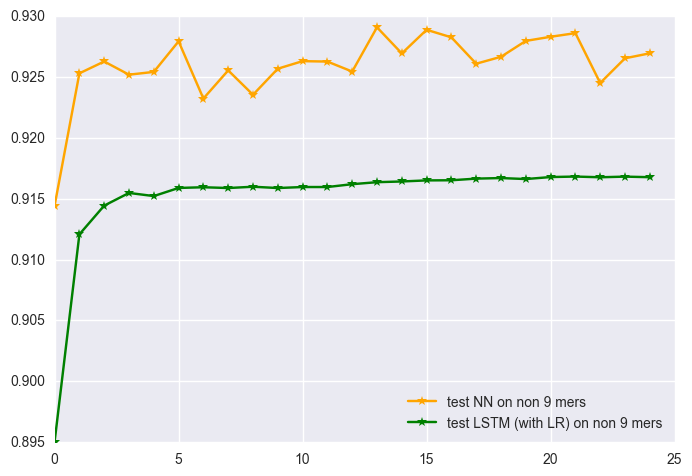

In [9]:
plt.plot( np.arange(0,25,1), non_nine_test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN on non 9 mers")
plt.plot( np.arange(0,25,1), non_nine_test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (with LR) on non 9 mers")

plt.legend(loc=4)

# kmer LSTM (without LR) vs kmer FFNN

In [10]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0





train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))
nine_train_nn_aucs = np.zeros((folds,n_epochs))
nine_test_nn_aucs = np.zeros((folds,n_epochs))
non_nine_train_nn_aucs = np.zeros((folds,n_epochs))
non_nine_test_nn_aucs = np.zeros((folds,n_epochs))


train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    

    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
  
    
    for epoch in range(n_epochs):
        
        
        
        
        # nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped = regroup_together(nn.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped = regroup_together(nn.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped = regroup_together(nn.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped = regroup_together(nn.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped)     
        nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped)
        non_nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped)     
        non_nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped)
        
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        nine_train_nn_aucs[i][epoch]=nine_train_nn_auc
        nine_test_nn_aucs[i][epoch]=nine_test_nn_auc
        non_nine_train_nn_aucs[i][epoch]=non_nine_train_nn_auc
        non_nine_test_nn_aucs[i][epoch]=non_nine_test_nn_auc
        
        
        
        #lstm 
        
        lstm.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_lstm, nb_epoch=1)
    
    
        train_pred_lstm_grouped = regroup_together(lstm.predict(X_train), weights_train, original_indices_train)
        test_pred_lstm_grouped = regroup_together(lstm.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500),train_pred_lstm_grouped)
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500),test_pred_lstm_grouped)
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500),nine_train_pred_lstm_grouped)
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500),nine_test_pred_lstm_grouped)
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500),non_nine_train_pred_lstm_grouped)
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500),non_nine_test_pred_lstm_grouped)
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc
        
        print("All: ", test_nn_auc, test_lstm_auc, epoch, i)
        print("9mer: ", nine_test_nn_auc, nine_test_lstm_auc, epoch, i)
        print("non9mer: ", non_nine_test_nn_auc ,non_nine_test_lstm_auc, epoch, i)
  

Epoch 1/1
21873/21873 [==============================] - 1s - loss: 0.0134     
Epoch 1/1
21873/21873 [==============================] - 26s - loss: 0.0165    
All:  0.935455175384 0.870095475312 0 0
9mer:  0.944874375913 0.878359858646 0 0
non9mer:  0.911592428449 0.84702845942 0 0
Epoch 1/1
21873/21873 [==============================] - 1s - loss: 0.0087     
Epoch 1/1
21873/21873 [==============================] - 26s - loss: 0.0128    
All:  0.942129350944 0.907382214267 1 0
9mer:  0.952315365459 0.916455562592 1 0
non9mer:  0.915346013899 0.883023791869 1 0
Epoch 1/1
21873/21873 [==============================] - 0s - loss: 0.0084     
Epoch 1/1
21873/21873 [==============================] - 16s - loss: 0.0111    
All:  0.944141234972 0.917115461275 2 0
9mer:  0.953337418111 0.925595682493 2 0
non9mer:  0.919582449545 0.894497232234 2 0
Epoch 1/1
21873/21873 [==============================] - 0s - loss: 0.0083     
Epoch 1/1
21873/21873 [==============================] - 22s - los

KeyboardInterrupt: 

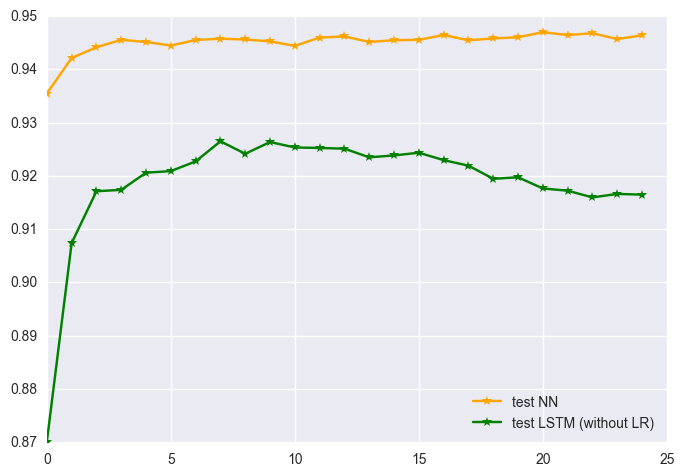

In [11]:
plt.plot( np.arange(0,25,1), test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN")
plt.plot( np.arange(0,25,1), test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (without LR)")

plt.legend(loc=4)

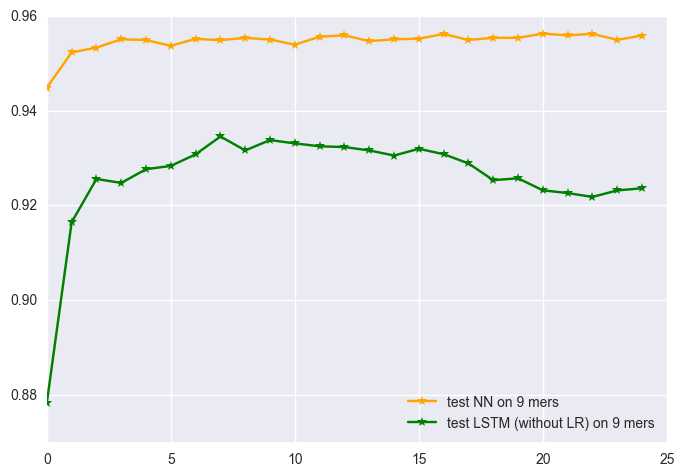

In [12]:
plt.plot( np.arange(0,25,1), nine_test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN on 9 mers")
plt.plot( np.arange(0,25,1), nine_test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (without LR) on 9 mers")

plt.legend(loc=4)

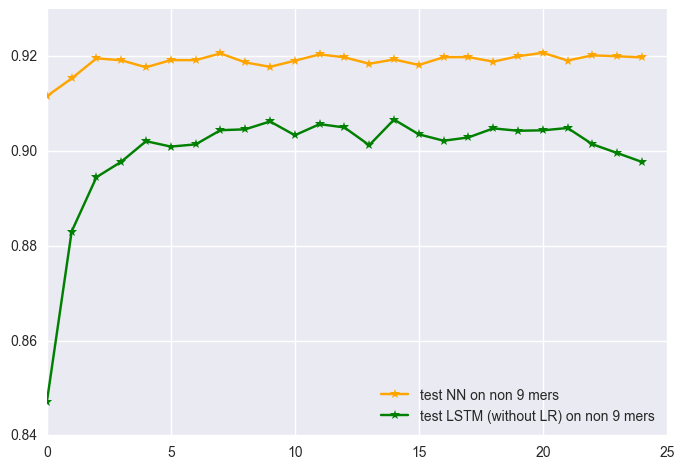

In [13]:
plt.plot( np.arange(0,25,1), non_nine_test_nn_aucs[0,0:25],color='orange',marker='*', linestyle='-', label ="test NN on non 9 mers")
plt.plot( np.arange(0,25,1), non_nine_test_lstm_aucs[0,0:25],color='g',marker='*', linestyle='-', label ="test LSTM (without LR) on non 9 mers")

plt.legend(loc=4)

# kmer LSTM (with LR) vs kmer FFNN vs plain LSTM (with LR)

In [12]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0





train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))
nine_train_nn_aucs = np.zeros((folds,n_epochs))
nine_test_nn_aucs = np.zeros((folds,n_epochs))
non_nine_train_nn_aucs = np.zeros((folds,n_epochs))
non_nine_test_nn_aucs = np.zeros((folds,n_epochs))


train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))


train_lstm_plain_aucs = np.zeros((folds,n_epochs))
test_lstm_plain_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_plain_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_plain_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_plain_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_plain_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    

    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # kmer lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32, mask_zero = False)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr=0.01)
    lstm.compile(optimizer = adam, loss='mean_squared_error')
    
    # plain lstm
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_plain = Model(input = sequence, output = output)
    adam_plain = Adam(lr=0.01)
    lstm_plain.compile(optimizer = adam_plain, loss='mean_squared_error')
    
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
  
    
    for epoch in range(n_epochs):
        
        
        
        
        # kmer nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped = regroup_together(nn.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped = regroup_together(nn.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped = regroup_together(nn.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped = regroup_together(nn.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped)     
        nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped)
        non_nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped)     
        non_nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped)
        
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        nine_train_nn_aucs[i][epoch]=nine_train_nn_auc
        nine_test_nn_aucs[i][epoch]=nine_test_nn_auc
        non_nine_train_nn_aucs[i][epoch]=non_nine_train_nn_auc
        non_nine_test_nn_aucs[i][epoch]=non_nine_test_nn_auc
        
        
        
        #kmer lstm 
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_lstm, nb_epoch=1)
    
    
        train_pred_lstm_grouped = regroup_together(lstm.predict(X_train), weights_train, original_indices_train)
        test_pred_lstm_grouped = regroup_together(lstm.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_lstm_grouped = regroup_together(lstm.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500),train_pred_lstm_grouped)
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500),test_pred_lstm_grouped)
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500),nine_train_pred_lstm_grouped)
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500),nine_test_pred_lstm_grouped)
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500),non_nine_train_pred_lstm_grouped)
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500),non_nine_test_pred_lstm_grouped)
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc
        
        
        # lstm 
        adam_plain.lr.set_value(0.01*(epoch+1)**(-2))
        lstm_plain.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_plain.predict(X[train_idx]))
        test_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_plain.predict(X[test_idx]))
        nine_train_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500),lstm_plain.predict(X[nine_train_idx]))
        nine_test_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500),lstm_plain.predict(X[nine_test_idx]))
        non_nine_train_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500),lstm_plain.predict(X[non_nine_train_idx]))
        non_nine_test_lstm_plain_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500),lstm_plain.predict(X[non_nine_test_idx]))
        
        train_lstm_plain_aucs[i][epoch]=train_lstm_plain_auc
        test_lstm_plain_aucs[i][epoch]=test_lstm_plain_auc
        nine_train_lstm_plain_aucs[i][epoch]=nine_train_lstm_plain_auc
        nine_test_lstm_plain_aucs[i][epoch]=nine_test_lstm_plain_auc
        non_nine_train_lstm_plain_aucs[i][epoch]=non_nine_train_lstm_plain_auc
        non_nine_test_lstm_plain_aucs[i][epoch]=non_nine_test_lstm_plain_auc
        
        print("All: ", test_nn_auc, test_lstm_auc, test_lstm_plain_auc, epoch, i)
        print("9mer: ", nine_test_nn_auc, nine_test_lstm_auc, nine_test_lstm_plain_auc,epoch, i)
        print("non9mer: ", non_nine_test_nn_auc ,non_nine_test_lstm_auc, non_nine_test_lstm_plain_auc, epoch, i)
  

Epoch 1/1
21613/21613 [==============================] - 1s - loss: 0.0157     
Epoch 1/1
21613/21613 [==============================] - 14s - loss: 0.0130    
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0430     
All:  0.934328173375 0.925473684211 0.930659885007 0 0
9mer:  0.947316545624 0.939068352472 0.947701654738 0 0
non9mer:  0.897390404376 0.886871759127 0.879447454298 0 0
Epoch 1/1
21613/21613 [==============================] - 0s - loss: 0.0089     
Epoch 1/1
21613/21613 [==============================] - 17s - loss: 0.0091    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0275    
All:  0.945468376824 0.942670942061 0.941175143742 1 0
9mer:  0.959203052737 0.956036893101 0.955537482195 1 0
non9mer:  0.90583911542 0.903214734552 0.898193031926 1 0
Epoch 1/1
21613/21613 [==============================] - 1s - loss: 0.0084     
Epoch 1/1
21613/21613 [==============================] - 21s - loss: 0.0079    
Epoch 1/1
6376/6376 [====

KeyboardInterrupt: 

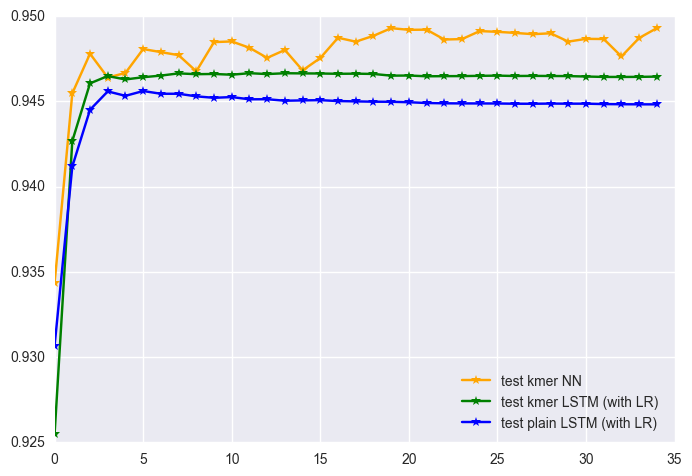

In [13]:
plt.plot( np.arange(0,35,1), test_nn_aucs[0,0:35],color='orange',marker='*', linestyle='-', label ="test kmer NN ")
plt.plot( np.arange(0,35,1), test_lstm_aucs[0,0:35],color='g',marker='*', linestyle='-', label ="test kmer LSTM (with LR) ")
plt.plot( np.arange(0,35,1), test_lstm_plain_aucs[0,0:35],color='b',marker='*', linestyle='-', label ="test plain LSTM (with LR) ")

plt.legend(loc=4)

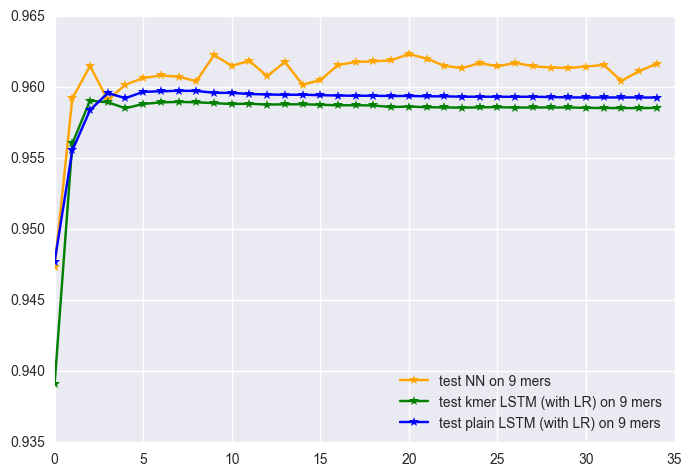

In [14]:
plt.plot( np.arange(0,35,1), nine_test_nn_aucs[0,0:35],color='orange',marker='*', linestyle='-', label ="test NN on 9 mers")
plt.plot( np.arange(0,35,1), nine_test_lstm_aucs[0,0:35],color='g',marker='*', linestyle='-', label ="test kmer LSTM (with LR) on 9 mers")
plt.plot( np.arange(0,35,1), nine_test_lstm_plain_aucs[0,0:35],color='b',marker='*', linestyle='-', label ="test plain LSTM (with LR) on 9 mers")

plt.legend(loc=4)

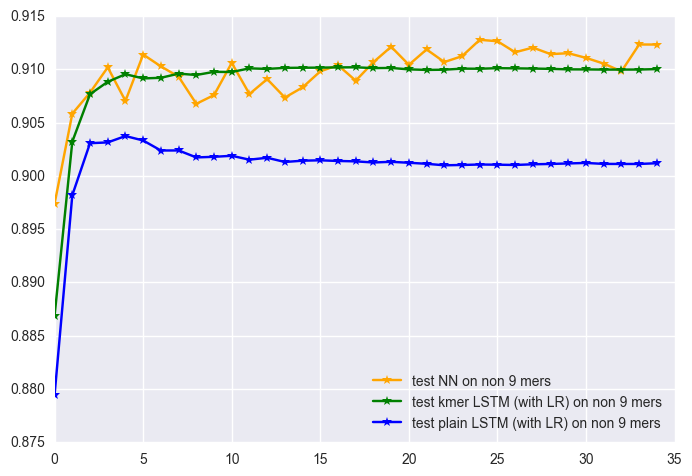

In [15]:
plt.plot( np.arange(0,35,1), non_nine_test_nn_aucs[0,0:35],color='orange',marker='*', linestyle='-', label ="test NN on non 9 mers")
plt.plot( np.arange(0,35,1), non_nine_test_lstm_aucs[0,0:35],color='g',marker='*', linestyle='-', label ="test kmer LSTM (with LR) on non 9 mers")
plt.plot( np.arange(0,35,1), non_nine_test_lstm_plain_aucs[0,0:35],color='b',marker='*', linestyle='-', label ="test plain LSTM (with LR) on non 9 mers")

plt.legend(loc=4)

In [9]:
len(train_idx), len(test_idx)

(6376, 3189)

In [10]:
len(nine_train_idx), len(non_nine_train_idx)

(4633, 1743)

In [11]:
len(nine_test_idx), len(non_nine_test_idx)

(2328, 861)